---
title: "Spectral Clustering. What is it?"
image: spectral.png
format:
  html:
    toc: true
author: "Jun Ryu"
date: "2023-06-21"
categories: [python, ML]
---

## Preface  

> In this post, we will explore a simple version of the *spectral clustering* algorithm for clustering data points. Spectral clustering is an important tool for identifying meaningful parts of data sets with complex structure. 

### Notation

In all the math below: 

- Boldface capital letters like $\mathbf{A}$ refer to matrices (2d arrays of numbers). 
- Boldface lowercase letters like $\mathbf{v}$ refer to vectors (1d arrays of numbers). 
- $\mathbf{A}\mathbf{B}$ refers to a matrix-matrix product (`A@B`). $\mathbf{A}\mathbf{v}$ refers to a matrix-vector product (`A@v`). 

## Introduction

To begin, let's look at an example where we *don't* need spectral clustering. 

In [1]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

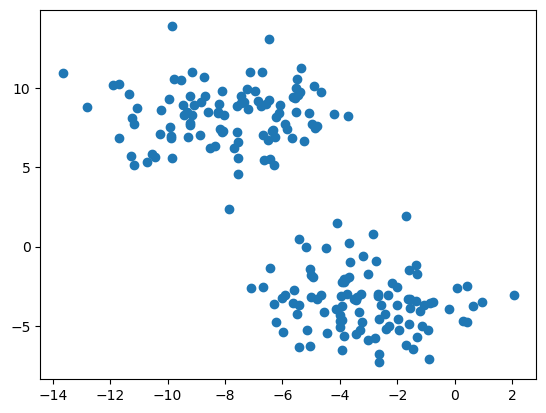

In [2]:
n = 200
np.random.seed(1111)
X, y = datasets.make_blobs(n_samples=n, shuffle=True, random_state=None, centers = 2, cluster_std = 2.0)
plt.scatter(X[:,0], X[:,1])

*Clustering* refers to the task of separating this data set into the two natural "blobs." K-means is a very common way to achieve this task, which has good performance on circular-ish blobs like these: 

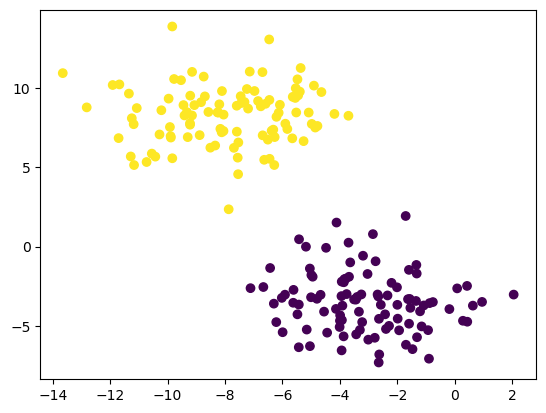

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(X)

plt.scatter(X[:,0], X[:,1], c = km.predict(X))

#### Harder Clustering

That was all well and good, but what if our data is "shaped weird"? 

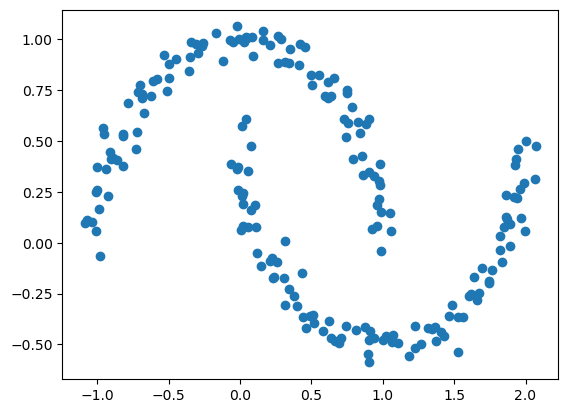

In [4]:
np.random.seed(1234)
n = 200
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:,0], X[:,1])

We can still make out two meaningful clusters in the data, but now they aren't blobs but crescents. As before, the Euclidean coordinates of the data points are contained in the matrix `X`, while the labels of each point are contained in `y`. Now k-means won't work so well, because k-means is, by design, looking for circular clusters. 

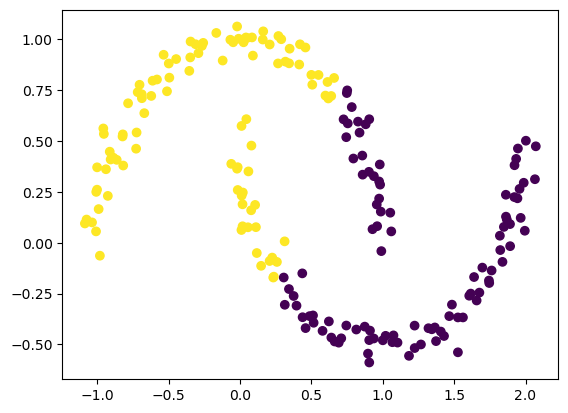

In [5]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Whoops! That's not right! 

As we'll see, spectral clustering is able to correctly cluster the two crescents. In the following parts, we will derive and implement spectral clustering.

## Part A

In this part, we will construct the *similarity matrix* $\mathbf{A}$. $\mathbf{A}$ should be a matrix (2d `np.ndarray`) with shape `(n, n)` (recall that `n` is the number of data points). 

When constructing the similarity matrix, we will use a parameter `epsilon`. Entry `A[i,j]` should be equal to `1` if `X[i]` (the coordinates of data point `i`) is within distance `epsilon` of `X[j]` (the coordinates of data point `j`), and `0` otherwise. 

**For this matrix, the diagonal entries `A[i,i]` should all be equal to zero.** We will use `epsilon = 0.4` for now. 

In [6]:
from sklearn.metrics import pairwise_distances

def construct_similarity_matrix(X, epsilon):
    """
    Constructs the similarity matrix
    Args:
    X: original matrix containing coordinates for all data points
    epsilon: the benchmark distance for classifying 'similarity'
    Return: 
    similarity_matrix: a n by n similarity matrix
    """
    
    distances = pairwise_distances(X)
    similarity_matrix = np.where(distances <= epsilon, 1, 0)
    np.fill_diagonal(similarity_matrix, 0) # diagonal entries are 0

    return similarity_matrix

A = construct_similarity_matrix(X, 0.4)
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

## Part B

The matrix `A` now contains information about which points are near (within distance `epsilon`) which other points. We now pose the task of clustering the data points in `X` as the task of partitioning the rows and columns of `A`. 

Let $d_i = \sum_{j = 1}^n a_{ij}$ be the $i$th row-sum of $\mathbf{A}$, which is also called the *degree* of $i$. Let $C_0$ and $C_1$ be two clusters of the data points. We assume that every data point is in either $C_0$ or $C_1$. The cluster membership as being specified by `y`. We think of `y[i]` as being the label of point `i`. So, if `y[i] = 1`, then point `i` (and therefore row $i$ of $\mathbf{A}$) is an element of cluster $C_1$.  

The *binary norm cut objective* of a matrix $\mathbf{A}$ is the function 

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

In this expression, 

* $\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$ is the *cut* of the clusters $C_0$ and $C_1$. 
* $\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$). The *volume* of cluster $C_0$ is a measure of the size of the cluster.

A pair of clusters $C_0$ and $C_1$ is considered to be a "good" partition of the data when $N_{\mathbf{A}}(C_0, C_1)$ is small. To see why, let's look at each of the two factors in this objective function separately. 


#### B.1 The Cut Term

First, the cut term $\mathbf{cut}(C_0, C_1)$ is the number of nonzero entries in $\mathbf{A}$ that relate points in cluster $C_0$ to points in cluster $C_1$. Saying that this term should be small is the same as saying that points in $C_0$ shouldn't usually be very close to points in $C_1$. 

Here, we will write a function called `cut(A,y)` to compute the cut term.

In [7]:
def cut(A, y):
    """
    Computes the cut term
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    cut_value: the cut term
    """
    n = A.shape[0]
    cut_value = 0

    for i in range(n):
        for j in range(n):
            if y[i] != y[j]: # these are in different clusters
                cut_value += A[i, j]
    return cut_value/2 # avoid double-counting

Now, we will compute the cut objective for the true clusters `y`. Then, we will generate a random vector of random labels of length `n`, with each label equal to either 0 or 1, and check the cut objective for the random labels. We should get that the cut objective for the true labels is *much* smaller than the cut objective for the random labels. 

In [8]:
cut_true = cut(A, y)

np.random.seed(42)  
y_random = np.random.randint(0, 2, size=n) # random labels
cut_random = cut(A, y_random)

print(cut_true)
print(cut_random)

13.0
1147.0


This shows that this part of the cut objective indeed favors the true clusters over the random ones. 

#### B.2 The Volume Term 

Now, the *volume term*. As mentioned above, the *volume* of cluster $C_0$ is a measure of how "big" cluster $C_0$ is. If we choose cluster $C_0$ to be small, then $\mathbf{vol}(C_0)$ will be small and $\frac{1}{\mathbf{vol}(C_0)}$ will be large, leading to an undesirable higher objective value. 

Synthesizing, the binary normcut objective asks us to find clusters $C_0$ and $C_1$ such that:

1. There are relatively few entries of $\mathbf{A}$ that join $C_0$ and $C_1$. 
2. Neither $C_0$ and $C_1$ are too small. 

We will write a function called `vols(A,y)` which computes the volumes of $C_0$ and $C_1$, returning them as a tuple. For example, `v0, v1 = vols(A,y)` should result in `v0` holding the volume of cluster `0` and `v1` holding the volume of cluster `1`. Then, we will write a function called `normcut(A,y)` which uses `cut(A,y)` and `vols(A,y)` to compute the binary normalized cut objective of a matrix `A` with clustering vector `y`. 

In [9]:
def vols(A, y):
    """
    Computes the volume term
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    v0, v1: the volumes of cluster 0 and cluster 1
    """
    v0 = np.sum(A[np.where(y == 0)])  # volume of cluster 0
    v1 = np.sum(A[np.where(y == 1)])  # volume of cluster 1
    return v0, v1

def normcut(A, y):
    """
    Computes the binary norm cut objective
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    normcut_value: the binary norm cut objective
    """
    cut_value = cut(A, y)
    v0, v1 = vols(A, y)
    normcut_value = cut_value * (1 / v0 + 1 / v1)
    return normcut_value

Now, we will compare the `normcut` objective using both the true labels `y` and the fake labels we generated above.

In [10]:
print(normcut(A,y))
print(normcut(A,y_random))

0.011518412331615225
1.0159594530373053


We notice that the normcut for the true labels is significantly smaller than the normcut for the fake labels.

## Part C

We have now defined a normalized cut objective which takes small values when the input clusters are (a) joined by relatively few entries in $A$ and (b) not too small. One approach to clustering is to try to find a cluster vector `y` such that `normcut(A,y)` is small. However, this is an NP-hard combinatorial optimization problem, which means that may not be possible to find the best clustering in practical time, even for relatively small data sets. We need a math trick! 

Here's the trick: define a new vector $\mathbf{z} \in \mathbb{R}^n$ such that: 

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$


Note that the signs of  the elements of $\mathbf{z}$ contain all the information from $\mathbf{y}$: if $i$ is in cluster $C_0$, then $y_i = 0$ and $z_i > 0$. 

Next, by linear algebra, we can show that 

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix with nonzero entries $d_{ii} = d_i$, and  where $d_i = \sum_{j = 1}^n a_i$ is the degree (row-sum) from before. 

Now, we will achieve three tasks in this part:

1. We will write a function called `transform(A,y)` to compute the appropriate $\mathbf{z}$ vector given `A` and `y`, using the formula above. 
2. Then, we will check the equation above that relates the matrix product to the normcut objective, by computing each side separately and checking that they are equal. 
3. We will also check the identity $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$, where $\mathbb{1}$ is the vector of `n` ones (i.e. `np.ones(n)`). This identity effectively says that $\mathbf{z}$ should contain roughly as many positive as negative entries.  

::: {.callout-warning}
The equation above is exact, but computer arithmetic is not! `np.isclose(a,b)` is a good way to check if `a` is "close" to `b`, in the sense that they differ by less than the smallest amount that the computer is (by default) able to quantify. 
:::

In [11]:
def transform(A, y):
    """
    Transforms into the z vector
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    z: a new z vector
    """
    v0, v1 = vols(A, y)
    z = np.zeros_like(y, dtype=np.float32)
    z[y == 0] = 1 / v0
    z[y == 1] = -1 / v1
    return z

In [12]:
D = np.diag(np.sum(A, axis=1)) # by definition
def check_normcut(A, y):
    """
    Checks for equality of normcut objective to the matrix product
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    True if equal, False otherwise
    """
    z = transform(A, y)
    num = z.T @ (D - A) @ z
    denom = z.T @ D @ z
    mat_result = num / denom
    return np.isclose(mat_result, normcut(A,y))

check_normcut(A, y)

True

In [13]:
def check_identity(A, y):
    """
    Checks that z contains as many positive as negative entries
    Args:
    A: a similarity matrix
    y: the labels for the clusters
    Return: 
    True if equal, False otherwise
    """
    z = transform(A, y)
    zD_ones = z.T @ D @ np.ones(n)
    return np.isclose(zD_ones, 0, atol = 1e-7)

check_identity(A,y)

True

## Part D

In the last part, we saw that the problem of minimizing the normcut objective is mathematically related to the problem of minimizing the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. It's actually possible to bake this condition into the optimization, by substituting for $\mathbf{z}$ the orthogonal complement of $\mathbf{z}$ relative to $\mathbf{D}\mathbf{1}$. In the code below, `orth_obj` function is defined, which handles this. 

Next, we will use the `minimize` function from `scipy.optimize` to minimize the function `orth_obj` with respect to $\mathbf{z}$. Note that this computation might take a little while. Explicit optimization can be pretty slow! We will give the minimizing vector a name `z_min`. 

In [14]:
def orth(u, v):
    return (u @ v) / (v @ v) * v

e = np.ones(n) 

d = D @ e

def orth_obj(z):
    z_o = z - orth(z, d)
    return (z_o @ (D - A) @ z_o)/(z_o @ D @ z_o)

In [15]:
from scipy.optimize import minimize

z = np.random.rand(n)
result = minimize(orth_obj, z)
z_min = result.x
z_min

array([ 33.56667894,  26.37316335, -21.39702164, -20.55071611,
       -23.49521762, -22.22583467, -20.58454322, -20.56529733,
        17.32151832,  12.92074237,  22.78649358, -21.6425766 ,
        -3.93000947,  20.62219017,  30.48792501,  25.65359739,
        19.53087355, -21.36003169, -24.4363914 , -22.78690083,
        22.22146152,  10.64059859,  33.58854065, -20.60080751,
       -26.02027458,  15.19921269, -20.69525676,  21.13293901,
        18.95811059, -21.00525524, -20.68958909,  34.04993781,
        25.19032729,  24.50867291,  18.27983536,  27.77539342,
       -26.00158657,  33.13506718,  29.25427799, -22.3317278 ,
        24.42996414, -21.21719816, -21.04328742, -25.90130481,
       -25.78291401, -21.18474707, -21.30937214,  22.4242508 ,
        30.07309516,   4.23764119, -21.26852308, -20.67189647,
        33.57741684,  20.975337  , -26.22610425, -24.91284151,
        27.89415393,  11.56344857,  33.17995203, -21.19698778,
       -26.07863767, -24.07099584,  17.17040637, -21.31

::: {.callout-note}
There's a cheat going on here! We originally specified that the entries of $\mathbf{z}$ should take only one of two values (back in Part C), whereas now we're allowing the entries to have *any* value! This means that we are no longer exactly optimizing the normcut objective, but rather an approximation. This cheat is so common that deserves a name: it is called the *continuous relaxation* of the normcut problem. 
:::

## Part E

Recall that, by design, only the sign of `z_min[i]` actually contains information about the cluster label of data point `i`. Thus, we plot the original data, using one color for points such that `z_min[i] < 0` and another color for points such that `z_min[i] >= 0`. 

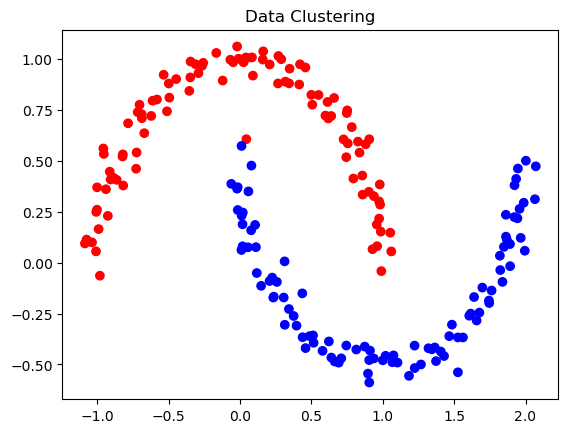

In [16]:
import matplotlib.pyplot as plt

colors = ['red' if z < 0 else 'blue' for z in z_min]

plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title('Data Clustering')
plt.show()

This looks great, but can we make the process quicker?

## Part F

Explicitly optimizing the orthogonal objective is  *way* too slow to be practical. If spectral clustering required that we do this each time, no one would use it. 

The reason that spectral clustering actually matters, and indeed the reason that spectral clustering is called *spectral* clustering, is that we can actually solve the problem from Part E using eigenvalues and eigenvectors of matrices. 

Recall that what we would like to do is minimize the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

with respect to $\mathbf{z}$, subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. 

The Rayleigh-Ritz Theorem states that the minimizing $\mathbf{z}$ must be the solution with smallest eigenvalue of the generalized eigenvalue problem 

$$ (\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{D}\mathbf{z}\;, \quad \mathbf{z}^T\mathbf{D}\mathbb{1} = 0$$

which is equivalent to the standard eigenvalue problem 

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$

Why is this helpful? Well, $\mathbb{1}$ is actually the eigenvector with smallest eigenvalue of the matrix $\mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$. 

> So, the vector $\mathbf{z}$ that we want must be the eigenvector with  the *second*-smallest eigenvalue. 

So, we will construct the matrix $\mathbf{L} = \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$, which is often called the (normalized) *Laplacian* matrix of the similarity matrix $\mathbf{A}$. Next, we will find the eigenvector corresponding to its second-smallest eigenvalue, and call it `z_eig`. Then, we will plot the data again, using the sign of `z_eig` as the color.

In [17]:
L = np.linalg.inv(D) @ (D - A)  # Laplacian matrix

eigenvalues, eigenvectors = np.linalg.eig(L)
idx = np.argsort(eigenvalues) # sort the eigenvalues
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

z_eig = eigenvectors[:, 1]
z_eig

array([ 0.09389207,  0.07736223, -0.06300698, -0.06253406, -0.07203744,
       -0.06844687, -0.05944786, -0.06009116,  0.05131329,  0.03946165,
        0.06620733, -0.06553515, -0.01103184,  0.05996065,  0.08757109,
        0.07501904,  0.0572584 , -0.06303476, -0.07571484, -0.07031429,
        0.0644712 ,  0.03290825,  0.09343953, -0.06278897, -0.07955868,
        0.04567633, -0.06045876,  0.06151979,  0.05555302, -0.06338615,
       -0.06034508,  0.09371443,  0.07336238,  0.07147172,  0.05389553,
        0.08160528, -0.07955868,  0.09261574,  0.08538788, -0.06813982,
        0.07110439, -0.06321393, -0.06346373, -0.07993405, -0.07933222,
       -0.06328915, -0.06307581,  0.06482837,  0.08710903,  0.01347952,
       -0.06233862, -0.06056617,  0.09343953,  0.06090757, -0.0796757 ,
       -0.07731147,  0.08189833,  0.03602595,  0.09290969, -0.06294241,
       -0.0798901 , -0.07415366,  0.05089988, -0.06505416,  0.05811411,
       -0.06897256, -0.0798901 , -0.07942743, -0.06238392,  0.09

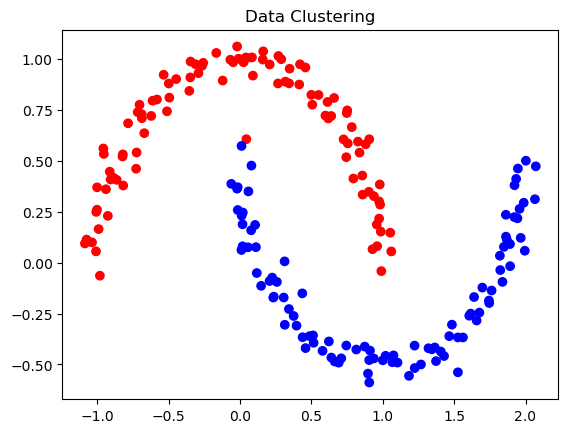

In [18]:
colors = ['red' if z < 0 else 'blue' for z in z_eig]

plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title('Data Clustering')
plt.show()

This looks essentially the same, but it took significantly less time!

## Part G

We will synthesize our results from all the previous parts. In particular, we will write a function called `spectral_clustering(X, epsilon)` which takes in the input data `X` (in the same format as Part A) and the distance threshold `epsilon` and performs spectral clustering, returning an array of binary labels indicating whether data point `i` is in group `0` or group `1`. We will demonstrate our function using the supplied data from the beginning of the problem.  

#### Outline

Given data, we need to: 

1. Construct the similarity matrix. 
2. Construct the Laplacian matrix. 
3. Compute the eigenvector with second-smallest eigenvalue of the Laplacian matrix. 
4. Return labels based on this eigenvector. 

In [19]:
def spectral_clustering(X, epsilon):
    """
    Performs spectral clustering
    Args:
    X: original matrix containing coordinates for all data points
    epsilon: the benchmark distance for classifying 'similarity'
    Return: 
    labels: 0 if in cluster 0, 1 if in cluster 1
    """
    distances = pairwise_distances(X)
    similarity_matrix = np.where(distances <= epsilon, 1, 0)
    np.fill_diagonal(similarity_matrix, 0)
    
    D = np.diag(np.sum(similarity_matrix, axis=1))
    L = np.linalg.inv(D) @ (D - similarity_matrix)
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    z_eig = eigenvectors[:, 1]
    labels = [0 if z < 0 else 1 for z in z_eig]
    return labels

Text(0.5, 1.0, 'Data Clustering')

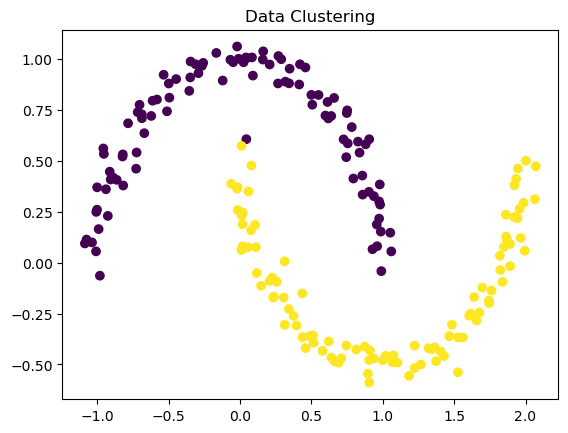

In [20]:
labels = spectral_clustering(X, 0.4)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title('Data Clustering')

## Part H

Let's run one more experiment using our function, by generating a different data set using `make_moons`. What happens when we increase the `noise`? Will spectral clustering still find the two half-moon clusters? For these experiments, we might find it useful to increase `n` to `1000` or so -- we can do this now, because of our fast algorithm!

Text(0.5, 1.0, 'Data Clustering')

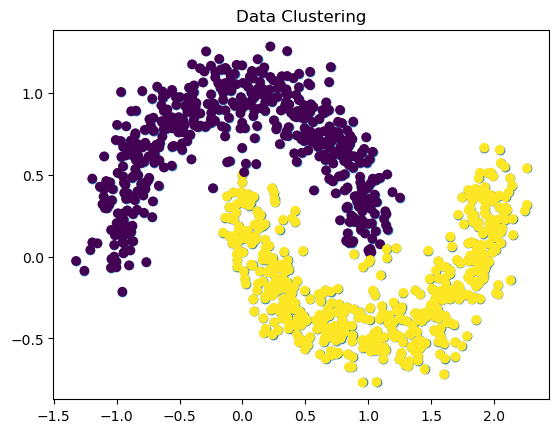

In [21]:
n = 1000
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.12, random_state=None)
plt.scatter(X[:,0], X[:,1])

labels = spectral_clustering(X, 0.4)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title('Data Clustering')

## Part I

Now let's try our spectral clustering function on another data set -- the bull's eye! 

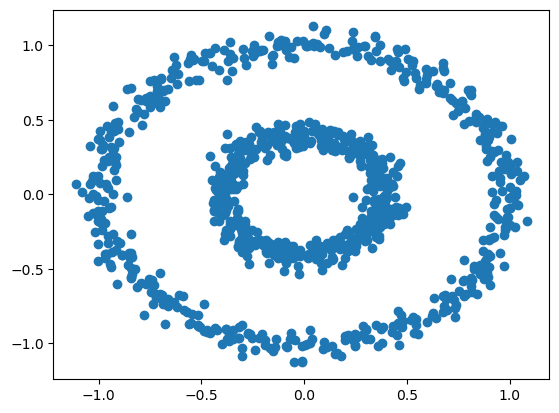

In [22]:
n = 1000
X, y = datasets.make_circles(n_samples=n, shuffle=True, noise=0.05, random_state=None, factor = 0.4)
plt.scatter(X[:,0], X[:,1])

There are two concentric circles. As before k-means will not do well here at all. 

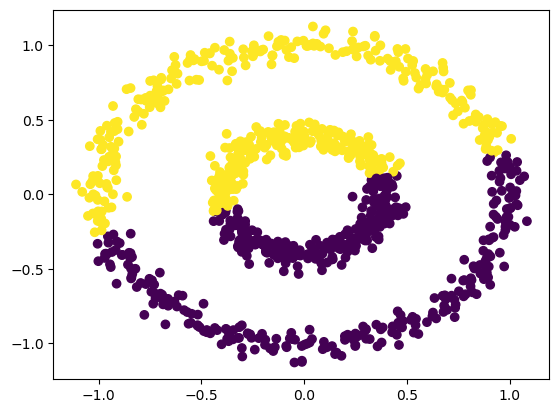

In [23]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Can our function successfully separate the two circles? Some experimentation here with the value of `epsilon` is likely to be required.

Text(0.5, 1.0, 'Data Clustering')

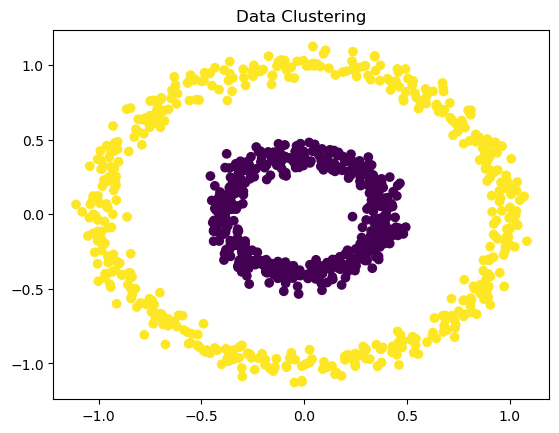

In [24]:
labels = spectral_clustering(X, 0.4)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title('Data Clustering')

Through experimentation, we find that an `epsilon` value of `0.4` is able to accurately cluster this data!